In [2]:
import numpy as np  
import pandas as pd  

from tensorflow.keras.models import Sequential  # For building the ANN
# from tensorflow.keras.layers import Dense, Dropout  # For adding layers to the ANN
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD  # Optimizers for training
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import StandardScaler, MinMaxScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix

import matplotlib.pyplot as plt  
import seaborn as sns

import pickle

In [3]:
# Load X_train
with open('/kaggle/input/overfitting-handled-pkl/X_train_combined (2).pkl', 'rb') as file:
    sparse_matrix1 = pickle.load(file)

X_train = sparse_matrix1.toarray()  # Convert to dense NumPy array

# Load X_test
with open('/kaggle/input/overfitting-handled-pkl/X_test_combined (2).pkl', 'rb') as file:
    sparse_matrix2 = pickle.load(file)

X_test = sparse_matrix2.toarray()  # Convert to dense NumPy array

# Load y_train
with open('/kaggle/input/overfitting-handled-pkl/y_train (1).pkl', 'rb') as file:
    y_train = pickle.load(file)

# Load y_test
with open('/kaggle/input/overfitting-handled-pkl/y_test (1).pkl', 'rb') as file:
    y_test = pickle.load(file)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# List of new column names for the last 48 columns
new_col_names = [
    "Study Results", "Enrollment", 'unique_name_count',
    'unique_state_count', 'unique_zip_count', 'unique_city_count',
    'unique_country_count', 'minimum_age_min', 'maximum_age_min',
    'healthy_volunteers', 'gender_based', 'total_dropouts',
    'unique_reasons', 'unique_periods', 'ADULT', 'OLDER_ADULT', 'CHILD',
    'EARLY_PHASE1', 'PHASE1', 'PHASE2', 'PHASE3', 'PHASE4', 'Funder_Type_FED',
    'Funder_Type_INDIV', 'Funder_Type_INDUSTRY', 'Funder_Type_NETWORK', 
    'Funder_Type_NIH', 'Funder_Type_OTHER', 'Funder_Type_OTHER_GOV', 
    'Funder_Type_UNKNOWN', 'mode_country_Bin_High_Freq', 
    'mode_country_Bin_Low_Freq', 'mode_country_Bin_Medium_Freq', 
    'mode_country_Bin_Missing', 'mode_city_Bin_High_Freq', 
    'mode_city_Bin_Low_Freq', 'mode_city_Bin_Medium_Freq', 
    'mode_city_Bin_Missing', 'mode_state_Bin_High_Freq', 
    'mode_state_Bin_Low_Freq', 'mode_state_Bin_Medium_Freq', 
    'mode_state_Bin_Missing', 'mode_name_Bin_High_Freq', 
    'mode_name_Bin_Medium_Freq', 'mode_name_Bin_Missing', 'Sex_ALL', 
    'Sex_FEMALE', 'Sex_MALE'
]

# Verify column counts before renaming
if X_train.shape[1] == 304:  # Ensure 304 columns are present
    updated_columns = list(X_train.columns[:256]) + new_col_names
    X_train.columns = updated_columns
    X_test.columns = updated_columns  # Assuming X_test has the same structure
else:
    print(f"Column count mismatch: expected 304, but got {X_train.shape[1]}")

In [4]:
# Define a custom callback to calculate and display R² scores
class R2ScoreCallback(Callback):
    def __init__(self, X_train, y_train, validation_data):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Training data predictions and R² score
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        train_r2 = r2_score(self.y_train, y_train_pred)

        # Validation data predictions and R² score
        X_val, y_val = self.validation_data
        y_val_pred = self.model.predict(X_val, verbose=0)
        val_r2 = r2_score(y_val, y_val_pred)

        # Print R² scores
        print(f"Epoch {epoch + 1}: Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}")

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Define the parameters
params = {
    "max_depth": 6,
    "learning_rate": 0.008268301670562767,
    "n_estimators": 2440,
    "min_child_weight": 5,
    "subsample": 0.8752620542712627,
    "colsample_bytree": 0.7745454016517448,
    "gamma": 1.529438834685792e-05,
    "reg_alpha": 1.6428565254928343e-05,
    "reg_lambda": 0.00013149326803447135,
    "objective": "reg:squarederror",
    "random_state": 42
}

# Initialize the model
model3 = xgb.XGBRegressor(**params)

# Train the model
model3.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="rmse", early_stopping_rounds=50, verbose=False)

# Predictions
y_pred = model3.predict(X_test)

# Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE: 12.545680237358818
R²: 0.41276646797438776


In [ ]:
import xgboost as xgb

# Assuming `model` is your trained XGBoost model
model3.save_model("xgboost_model.json")  # Saves the model in JSON format

In [ ]:
import xgboost as xgb

# Create an XGBoost Booster object
model3 = xgb.Booster()

# Load the model from the .json file
model3.load_model("/kaggle/input/xgboost/tensorflow2/default/1/xgboost_model.json")  # Replace with your actual file path

# The model is now loaded and can be used for predictions

In [8]:
feature_names = X_train.columns.tolist()

100%|===================| 13780/13792 [13:57<00:00]        

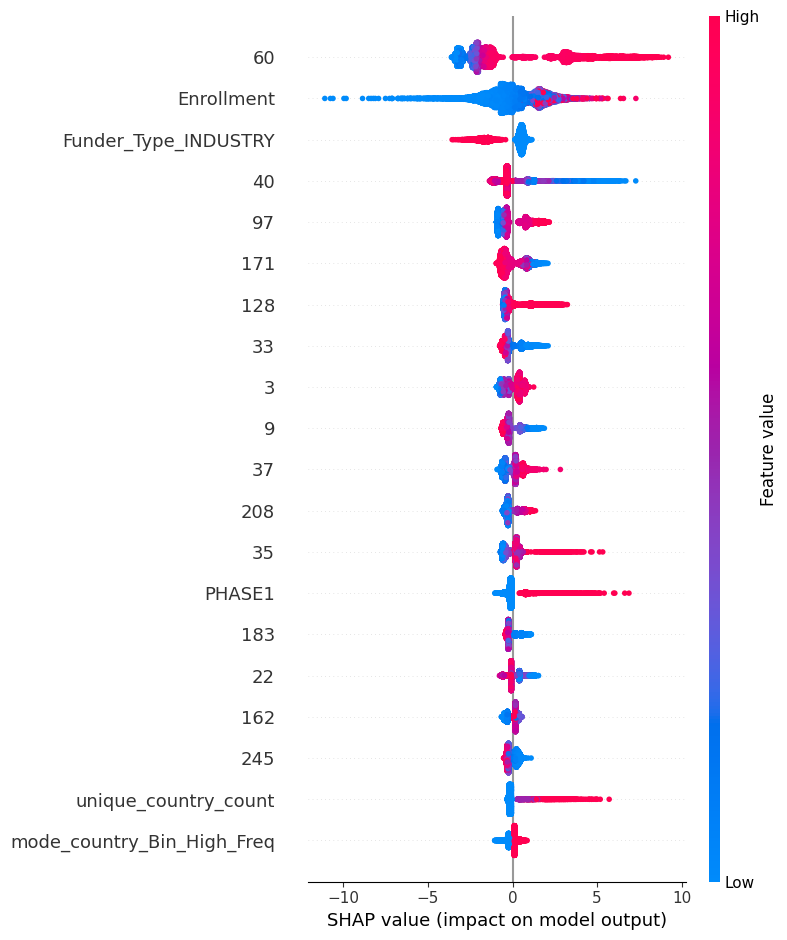

In [9]:
import shap
import matplotlib.pyplot as plt

# Use a small subset of rows for trial
X_train_sample = X_train.sample(frac=1, random_state=42)  # 1% of X_train
X_test_sample = X_test.sample(frac=1, random_state=42)    # 1% of X_test

# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(model3, X_train_sample)

# Compute SHAP values
shap_values = explainer(X_test_sample)

# Summary plot
# shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

# Beeswarm plot
# shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="dot", max_display=10)

plt.figure()  # Create a new figure for saving
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="dot")
plt.savefig("shap_beeswarm_xgboost_plot.png", bbox_inches='tight', dpi=300)
plt.close()  # Close the figure to avoid overlap

# Force plot for a single prediction
# shap.force_plot(explainer.expected_value[0], shap_values[0, :], X_test_sample.iloc[0, :], feature_names=feature_names)

In [ ]:
import shap
import matplotlib.pyplot as plt

# Use a small subset of rows for trial
X_train_sample = X_train.sample(frac=0.01, random_state=42)  # 1% of X_train
X_test_sample = X_test.sample(frac=0.01, random_state=42)    # 1% of X_test

# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(model3, X_train_sample)

# Compute SHAP values
shap_values = explainer(X_test_sample)

# Summary plot
# shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

# Beeswarm plot
# shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="dot", max_display=10)

plt.figure()  # Create a new figure for saving
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="dot", max_display=10)
plt.savefig("shap_beeswarm_xgboost_plot.png", bbox_inches='tight', dpi=300)
plt.close()  # Close the figure to avoid overlap

# Force plot for a single prediction
# shap.force_plot(explainer.expected_value[0], shap_values[0, :], X_test_sample.iloc[0, :], feature_names=feature_names)

In [25]:
print(y_test.mean())
print(np.median(y_test))
print(y_test.max())
print(y_test.min())

18.103175754060324
13.0
99
0


In [43]:
# Find the index of value 40
index_40 = np.where(y_test == 35)[0][0]  # [0] to get the first match

# Find the index of value 8
index_8 = np.where(y_test == 8)[0][1]    # [0] to get the first match

print("Index of 40:", index_40)
print("Index of 8:", index_8)

Index of 40: 7
Index of 8: 74


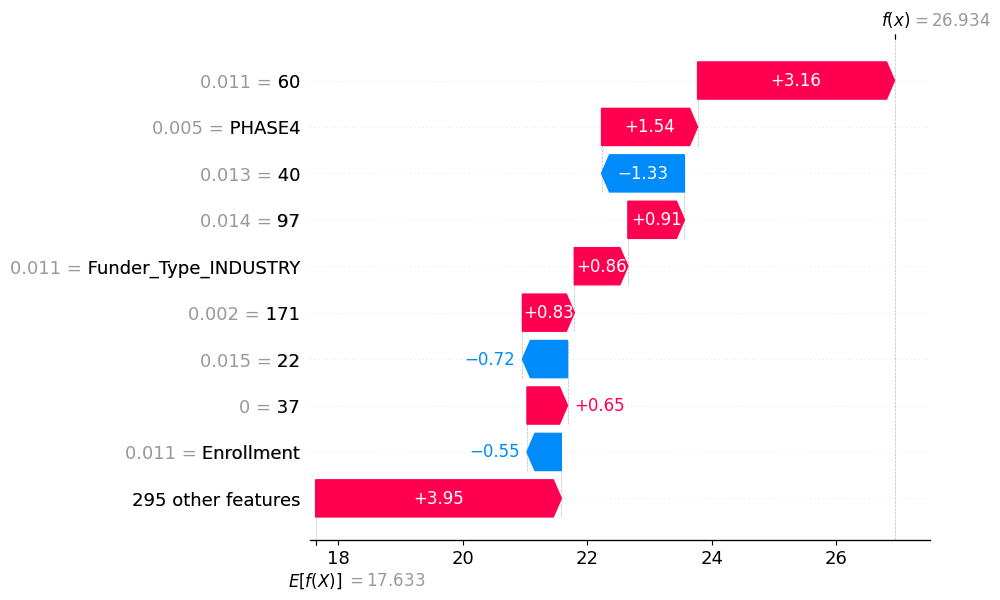

In [44]:
datapoint_index = 7 # Select a specific datapoint for the waterfall plot

# Convert feature values to strings for compatibility if necessary
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.values[datapoint_index],
        base_values=shap_values.base_values[datapoint_index],
        data=X_test[datapoint_index],  # Ensure feature values are correctly formatted
        feature_names=[str(name) for name in feature_names]  # Convert feature names to strings explicitly
    )
)

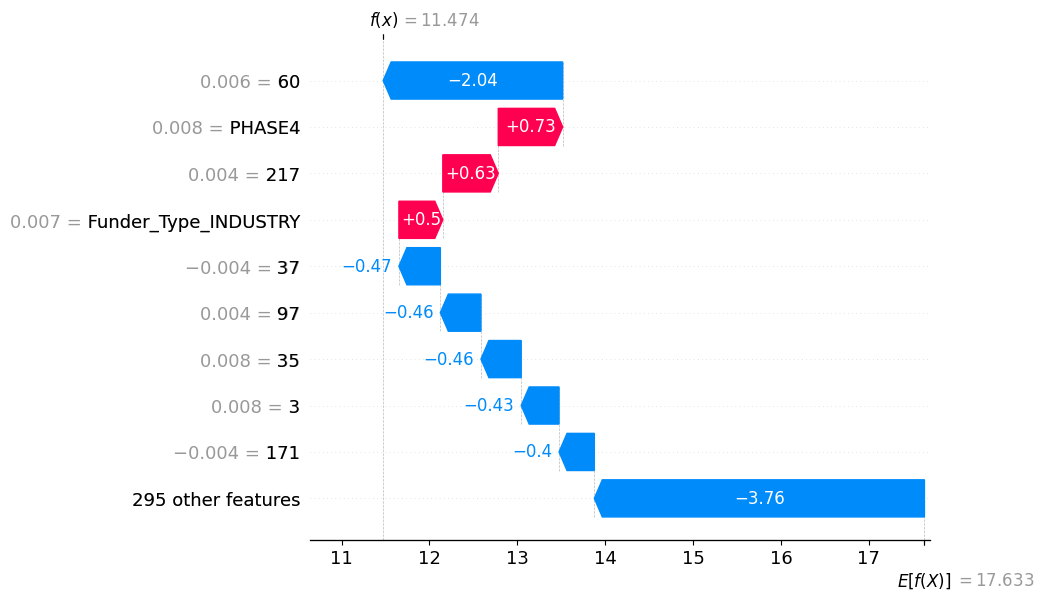

In [36]:
datapoint_index = 74  # Select a specific datapoint for the waterfall plot

# Convert feature values to strings for compatibility if necessary
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.values[datapoint_index],
        base_values=shap_values.base_values[datapoint_index],
        data=X_test[datapoint_index],  # Ensure feature values are correctly formatted
        feature_names=[str(name) for name in feature_names]  # Convert feature names to strings explicitly
    )
)